In [14]:
import cv2
import numpy as np
from torchvision.datasets import CocoCaptions
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize
import torchvision

## Unet

In [15]:
import Detection.GroundingDINO.groundingdino.datasets.transforms as T

transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )


In [16]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self,phase, transform):
        self.phase = phase
        
        if phase == 'train':
            self.dataset = CocoCaptions(root='./train2017', annFile='./annotations/captions_train2017.json')
        else:
            self.dataset = CocoCaptions(root='./val2017', annFile='./annotations/captions_val2017.json')
        
        self.transform = transform
        
        
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        
        org_img, caps = self.dataset[idx]

        img,_ = self.transform(org_img, None)
        
        random_idx = torch.randint(0,len(caps), (1,))
        
        if self.phase == 'train':
            return np.array(org_img), img, caps[random_idx]
        else:
            return np.array(org_img), img, caps[1]


In [17]:
from SResolution.TG_Umodels import *
from SResolution.Umodels import *

def select_model(down_scale, shape):
    if down_scale == 2:
        model = UNet2(3,3)
    elif down_scale == 4:
        model = TG_UNet4x2(3,3, shape)
    elif down_scale == 8:
        model = TG_UNet8x2(3,3, shape)

    return model

In [18]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [19]:

target_size = 512

down_scale = 2
input_shape = (512//down_scale,512//down_scale)
model = select_model(down_scale,input_shape)
patience = 5
L2 = nn.MSELoss()
L1 = nn.L1Loss()
per_loss = VGGPerceptualLoss()
lam = 0.6
epochs = 30
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
per_loss = per_loss.to(device)


print(device)


cuda:0


In [20]:
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler, DataLoader, Subset

trainDataset = CustomDataset('train', transform)

num_train_samples = 1000
sample_ds = Subset(trainDataset, np.arange(num_train_samples))
sample_sampler = RandomSampler(sample_ds)
# sample_dl = DataLoader(sample_ds, sampler=sample_sampler, batch_size=1)
train_dataloader = DataLoader(sample_ds, batch_size=1, shuffle=True)

valDataset = CustomDataset('val', transform)
num_train_samples = 200
sample_ds = Subset(valDataset, np.arange(num_train_samples))
sample_sampler = RandomSampler(sample_ds)
val_dataloader = DataLoader(sample_ds, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [21]:
print(len(train_dataloader), len(val_dataloader))

1000 200


In [22]:
oo, a, c = next(iter(train_dataloader))

oo.shape, a.shape, type(c)

(torch.Size([1, 640, 443, 3]), torch.Size([1, 3, 1155, 800]), tuple)

In [24]:
def tv_loss(x, beta = 0.5):
    '''Calculates TV loss for an image `x`.
        
    Args:
        x: image, torch.Variable of torch.Tensor
        beta: See https://arxiv.org/abs/1412.0035 (fig. 2) to see effect of `beta` 
    '''
    dh = torch.pow(x[:,:,:,1:] - x[:,:,:,:-1], 2) + 1e-16
    dw = torch.pow(x[:,:,1:,:] - x[:,:,:-1,:], 2) + 1e-16
    
    return torch.sum(torch.pow(dh[:, :, :-1] + dw[:, :, :, :-1], beta))

In [26]:
from Detection.GroundingDINO.groundingdino.util.inference import load_model, load_image_6, predict, annotate
from tqdm import tqdm 
import time
from torchvision.ops import box_convert
from torchvision.transforms.functional import center_crop
from copy import deepcopy
from torch.nn.functional import interpolate
from SResolution.TG_modules import down_sampler

DS = down_sampler(down_scale)
DS = DS.to(device)

iterable = range(epochs)

dect_model = load_model("./Detection/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "./Detection/GroundingDINO//weights/groundingdino_swint_ogc.pth")
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25


model.to(device)
send_tg_message(f'Start Server Computer X8')
best_loss = float("inf") 
best_tv_loss = float("inf")
best_result = None
scheduler_cnt = 0
lr_list = [lr]
for e in iterable:
    for p in ['Train', 'Test']:
        if p == 'Train':
            total_loss = 0
            total = 0
            model.train()
            DS.train()
            train_result = {}
            
            for oo, bimg, caps in tqdm(train_dataloader, desc='Train', leave=False):
                # print(f'{str(caps[0])}')
                train_result[f'{str(caps[0])}'] = {
                    'phrases': [],
                    'org_img':[],
                    'shape':[],
                    'cropped':[],
                    'padded':[],
                    'resized':[],
                    'output':[],
                    'c_padded':[]
                }
                
                i_caps = str(caps[0])
                bimg = bimg.squeeze()
                b_boxes, b_logits, b_phrases, b_encoded_text = predict(
                        model=dect_model,
                        image=bimg,
                        caption=i_caps,
                        box_threshold=BOX_TRESHOLD,
                        text_threshold=TEXT_TRESHOLD
                    )
                train_result[f'{str(caps[0])}']['phrases'].append(b_phrases)
                oo = oo.squeeze()
                h, w, c = oo.shape
                boxes2 = b_boxes * torch.Tensor([w, h, w, h])
                xyxy = box_convert(boxes=boxes2, in_fmt="cxcywh", out_fmt="xyxy").numpy()
                
                for xyxy_idx in range(len(xyxy)):
                    x1, y1, x2, y2 = xyxy[xyxy_idx].astype(int)
                    cropped_img = oo[y1:y2, x1:x2].permute(2,1,0)

                    _, h, w = cropped_img.shape
                    if h>w:
                        if h>target_size:
                            cropped_img = resize(cropped_img, (target_size, int(target_size*(w/h))))
                    else:
                        if w>target_size:
                            cropped_img = resize(cropped_img, (int(target_size*(h/w)), target_size))


                    train_result[f'{str(caps[0])}']['cropped'].append(cropped_img)
                    _, h, w = cropped_img.shape
                    train_result[f'{str(caps[0])}']['shape'].append((h,w))

                    # half_crop = resize(cropped_img, (h//down_scale, w//down_scale))
                    cc, hh, ww = cropped_img.shape
                    # cc, hh, ww = half_crop.shape
                    nh, nw = target_size - hh,  target_size - ww
                    padd = (nw//2, nw//2, nh//2, nh//2)
                    s_img = torch.nn.functional.pad(cropped_img, padd)
                    s_img = resize(s_img, (target_size//down_scale, target_size//down_scale))
                    train_result[f'{str(caps[0])}']['resized'].append(s_img)
                

                txt = b_encoded_text['encoded_text']


                
                
                for re, pa, sha in zip(train_result[f'{str(caps[0])}']['resized'], train_result[str(caps[0])]['cropped'],train_result[str(caps[0])]['shape'] ):
                    re, pa = re/255., pa/255.
                    # re, pa = re.float(), pa.float()
                    
                    re = re.unsqueeze(0)
                    # pa = pa.unsqueeze(0)
                    re = re.to(device)
                    # pa = pa.to(device)

                    pa = torch.tensor(pa).unsqueeze(0)
                    pa = pa.to(device)

                    output = model(re)
                    h,w = sha
                    c_output = center_crop(output, (h, w))
                    # c_pa = center_crop(pa, sha)
                    # print(c_output.shape, pa.shape)
                    # for_loss = interpolate(c_output, (h, w), mode='bicubic')
                    # for_loss = DS(c_output)

                    # loss = criterion(c_output, c_pa)
                    l2_loss = L2(c_output, pa)
                    l1_loss = L1(c_output, pa)
                    # p_loss = per_loss(c_output, pa)
                    # t_loss = tv_loss(c_output)
                    

                    
                    loss = l1_loss
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    total_loss += loss
                    total += 1
            avg_loss = total_loss / total
            train_text = f'Train | Epoch: [{e+1}/{epochs}] |  MSE: {avg_loss} | Total: {total}'
            print('='*len(train_text))
            print(train_text)

        else:
            total_loss = 0
            total = 0
            model.eval()
            DS.eval()
            test_result = {}
            
            with torch.no_grad():
                for oo, bimg, caps in tqdm(val_dataloader, desc='Test', leave=False):

                    test_result[f'{str(caps[0])}'] = {
                        'phrases': [],
                        'org_img':[],
                        'shape':[],
                        'cropped':[],
                        'padded':[],
                        'resized':[],
                        'output':[],
                        'c_padded':[],
                        'detect':[],
                        'for_loss':[]
                    }

                    i_caps = str(caps[0])
                    bimg = bimg.squeeze()
                    b_boxes, b_logits, b_phrases, b_encoded_text = predict(
                            model=dect_model,
                            image=bimg,
                            caption=i_caps,
                            box_threshold=BOX_TRESHOLD,
                            text_threshold=TEXT_TRESHOLD
                        )
                    test_result[f'{str(caps[0])}']['phrases'].append(b_phrases)
                    oo = oo.squeeze()
                    h, w, c = oo.shape
                    boxes2 = b_boxes * torch.Tensor([w, h, w, h])
                    xyxy = box_convert(boxes=boxes2, in_fmt="cxcywh", out_fmt="xyxy").numpy()
                    test_result[f'{str(caps[0])}']['org_img'].append(oo)

                    for xyxy_idx in range(len(xyxy)):
                        x1, y1, x2, y2 = xyxy[xyxy_idx].astype(int)
                        cropped_img = oo[y1:y2, x1:x2].permute(2,1,0)

                        _, h, w = cropped_img.shape
                        if h>w:
                            if h>target_size:
                                cropped_img = resize(cropped_img, (target_size, int(target_size*(w/h))))
                        else:
                            if w>target_size:
                                cropped_img = resize(cropped_img, (int(target_size*(h/w)), target_size))
                        
                        test_result[f'{str(caps[0])}']['cropped'].append(cropped_img)
                        _, hh, ww = cropped_img.shape
                        test_result[f'{str(caps[0])}']['shape'].append((hh,ww))
                        
                        nh, nw = target_size - hh,  target_size - ww
                        padd = (nw//2, nw//2, nh//2, nh//2)
                        s_img = torch.nn.functional.pad(cropped_img, padd)
                        s_img = resize(s_img, (target_size//down_scale, target_size//down_scale))
                        test_result[f'{str(caps[0])}']['resized'].append(s_img)
                
                        

                    # for b in test_result[f'{str(caps[0])}']['padded']:
                    #     _, h, w = b.shape
                    #     s_img = resize(b, (h//down_scale, w//down_scale))
                        
                    #     test_result[f'{str(caps[0])}']['resized'].append(s_img)

                    txt = b_encoded_text['encoded_text']

                    for re, pa, sha in zip(test_result[f'{str(caps[0])}']['resized'], test_result[str(caps[0])]['cropped'], test_result[str(caps[0])]['shape']):
                        re, pa = re/255., pa/255.
                        # re, pa = re.float(), pa.float()
                        # re = re.unsqueeze(0)
                        # pa = pa.unsqueeze(0)
                        # re = re.to(device)
                        # pa = pa.to(device)
                        re = re.unsqueeze(0)
                        # pa = pa.unsqueeze(0)
                        re = re.to(device)
                        # pa = pa.to(device)

                        pa = torch.tensor(pa).unsqueeze(0)
                        pa = pa.to(device)

                        output = model(re)
                        h, w = sha
                        c_output = center_crop(output, (h, w))
                        # c_pa = center_crop(pa, sha)
                        # for_loss = interpolate(c_output, (h, w), mode='bicubic')
                        # for_loss = DS(c_output)

                        test_result[f'{str(caps[0])}']['output'].append(c_output.detach().squeeze(0).cpu().numpy())
                        # test_result[f'{str(caps[0])}']['for_loss'].append(for_loss.detach().squeeze(0).cpu().numpy())
                        # test_result[f'{str(caps[0])}']['c_padded'].append(c_pa.detach().squeeze(0).cpu().numpy())
                        # test_result[f'{str(caps[0])}']['label'].append(pa.detach().squeeze(0).cpu().numpy())

                        l2_loss = L2(c_output, pa)
                        l1_loss = L1(c_output, pa)
                        # t_loss = tv_loss(c_output)

                        # p_loss = per_loss(c_output, pa)
                        # if e > epochs*0.5:
                        #     t_loss = tv_loss(c_output)
                        #     loss = l1_loss+1.5*l2_loss + t_loss + p_loss
                        # else:
                        loss = l1_loss
                        
                        total_loss += loss
                        total += 1
                avg_loss = total_loss / total
                test_text = f'Test  | Epoch: [{e+1}/{epochs}] |  MSE: {avg_loss} | Total: {total}'
                print(test_text)
                print('='*len(train_text))

                
                if avg_loss < best_loss:
                    print('Update results')
                    scheduler_cnt = 0
                    best_result = test_result
                    best_loss = avg_loss
                    best_model = deepcopy(model.state_dict())
                else:
                    scheduler_cnt += 1
                    print(scheduler_cnt)
                    if scheduler_cnt == patience:
                        optimizer.param_groups[0]['lr'] /= 2
                        lr_list.append(optimizer.param_groups[0]['lr'])
                        print(optimizer.param_groups[0]['lr'])
                        scheduler_cnt = 0
                        

send_tg_message(f'Finish Server Computer X8-inver_re_l1_l2_10epoch')

final text_encoder_type: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Train | Epoch: [1/30] |  MSE: 0.16072501242160797 | Total: 2810


Test:   0%|          | 0/200 [00:00<?, ?it/s]UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test  | Epoch: [1/30] |  MSE: 0.10607011616230011 | Total: 569
Update results


Train | Epoch: [2/30] |  MSE: 0.11751800030469894 | Total: 2784


Test  | Epoch: [2/30] |  MSE: 0.10235626995563507 | Total: 569
Update results


Train | Epoch: [3/30] |  MSE: 0.10348495095968246 | Total: 2696


Test  | Epoch: [3/30] |  MSE: 0.0745161771774292 | Total: 569
Update results


Train | Epoch: [4/30] |  MSE: 0.09536273777484894 | Total: 2743


Test  | Epoch: [4/30] |  MSE: 0.08678681403398514 | Total: 569
1


Train | Epoch: [5/30] |  MSE: 0.09114780277013779 | Total: 2725


Test  | Epoch: [5/30] |  MSE: 0.06850447505712509 | Total: 569
Update results


Train | Epoch: [6/30] |  MSE: 0.08705423772335052 | Total: 2783


Test  | Epoch: [6/30] |  MSE: 0.07197140902280807 | Total: 569
1


Train | Epoch: [7/30] |  MSE: 0.08480672538280487 | Total: 2729


Test  | Epoch: [7/30] |  MSE: 0.0875164270401001 | Total: 569
2


Train | Epoch: [8/30] |  MSE: 0.08484163880348206 | Total: 2760


Test  | Epoch: [8/30] |  MSE: 0.06903200596570969 | Total: 569
3


Train | Epoch: [9/30] |  MSE: 0.08007414638996124 | Total: 2770


Test  | Epoch: [9/30] |  MSE: 0.07010727375745773 | Total: 569
4


Train | Epoch: [10/30] |  MSE: 0.08032691478729248 | Total: 2722


Test  | Epoch: [10/30] |  MSE: 0.0693521797657013 | Total: 569
5
0.0005


Train | Epoch: [11/30] |  MSE: 0.0732116550207138 | Total: 2722


Test  | Epoch: [11/30] |  MSE: 0.08706206828355789 | Total: 569
1


Train | Epoch: [12/30] |  MSE: 0.07117439061403275 | Total: 2750


Test  | Epoch: [12/30] |  MSE: 0.06891321390867233 | Total: 569
2


Train | Epoch: [13/30] |  MSE: 0.07253274321556091 | Total: 2742


Test  | Epoch: [13/30] |  MSE: 0.07301009446382523 | Total: 569
3


Train | Epoch: [14/30] |  MSE: 0.06879400461912155 | Total: 2711


Test  | Epoch: [14/30] |  MSE: 0.06861303001642227 | Total: 569
4


Train | Epoch: [15/30] |  MSE: 0.07025562226772308 | Total: 2826


Test  | Epoch: [15/30] |  MSE: 0.06794174015522003 | Total: 569
Update results


Train | Epoch: [16/30] |  MSE: 0.06883643567562103 | Total: 2863


Test  | Epoch: [16/30] |  MSE: 0.08575735241174698 | Total: 569
1


Train | Epoch: [17/30] |  MSE: 0.06800464540719986 | Total: 2861


Test  | Epoch: [17/30] |  MSE: 0.06103803962469101 | Total: 569
Update results


Train | Epoch: [18/30] |  MSE: 0.06633007526397705 | Total: 2677


Test  | Epoch: [18/30] |  MSE: 0.057139914482831955 | Total: 569
Update results


Train | Epoch: [19/30] |  MSE: 0.06536150723695755 | Total: 2742


Test  | Epoch: [19/30] |  MSE: 0.058992207050323486 | Total: 569
1


Train | Epoch: [20/30] |  MSE: 0.0660778358578682 | Total: 2720


Test  | Epoch: [20/30] |  MSE: 0.056463465094566345 | Total: 569
Update results


Train | Epoch: [21/30] |  MSE: 0.06509844213724136 | Total: 2716


Test  | Epoch: [21/30] |  MSE: 0.09124474227428436 | Total: 569
1


Train | Epoch: [22/30] |  MSE: 0.0653047263622284 | Total: 2743


Test  | Epoch: [22/30] |  MSE: 0.060298752039670944 | Total: 569
2


Train | Epoch: [23/30] |  MSE: 0.06478668004274368 | Total: 2708


Test  | Epoch: [23/30] |  MSE: 0.0652928426861763 | Total: 569
3


Train | Epoch: [24/30] |  MSE: 0.06447139382362366 | Total: 2745


Test  | Epoch: [24/30] |  MSE: 0.055834829807281494 | Total: 569
Update results


Train | Epoch: [25/30] |  MSE: 0.0644138976931572 | Total: 2746


Test  | Epoch: [25/30] |  MSE: 0.07795652747154236 | Total: 569
1


Train | Epoch: [26/30] |  MSE: 0.06153218448162079 | Total: 2732


Test  | Epoch: [26/30] |  MSE: 0.0646865963935852 | Total: 569
2


Train | Epoch: [27/30] |  MSE: 0.06293363869190216 | Total: 2669


Test  | Epoch: [27/30] |  MSE: 0.08223183453083038 | Total: 569
3


Train | Epoch: [28/30] |  MSE: 0.06350293010473251 | Total: 2729


Test  | Epoch: [28/30] |  MSE: 0.07741507142782211 | Total: 569
4


Train | Epoch: [29/30] |  MSE: 0.06333853304386139 | Total: 2825


Test  | Epoch: [29/30] |  MSE: 0.07148198783397675 | Total: 569
5
0.00025


Train | Epoch: [30/30] |  MSE: 0.05914454907178879 | Total: 2797


Test  | Epoch: [30/30] |  MSE: 0.06908178329467773 | Total: 569
1


In [39]:
import os
from PIL import Image
from torchvision.transforms.functional import center_crop

def save_imgs(results, root='results'):
    

    for k in results.keys():
        # root = './resultsX4'
        if not os.path.isdir(root):
            os.mkdir(root)

        if not os.path.isdir(os.path.join(root, k)):
            os.mkdir(os.path.join(root, "_".join(k.split(" "))))
        save_path = os.path.join(root, "_".join(k.split(" ")))
        
        org = Image.fromarray(results[k]['org_img'][0].numpy())
        org.save(os.path.join(save_path, 'org.png'))
        if len(results[k]['phrases'][0]) == 0:
            print('ups')
            continue
        zz = 0
        for i in range(len(results[k]['phrases'][0])):
            save_path = os.path.join(root, "_".join(k.split(" ")))
            
            output = torch.tensor(results[k]['output'][i])
            output = Image.fromarray((np.clip(output.permute(2,1,0).numpy(),0,1)*255).astype(np.uint8))

            # noc_output = torch.tensor(results[k]['output'][i])
            # noc_output = Image.fromarray((np.clip(noc_output.permute(2,1,0).numpy(),0,1)*255).astype(np.uint8))
            # output = Image.fromarray((np.clip(center_crop(output, results[k]['shape'][i]).permute(2,1,0).numpy(),0,1)*255).astype(np.uint8))
            crop = results[k]['cropped'][i].permute(2,1,0)
            # detect = (np.clip(results[k]['for_loss'][i].transpose(2,1,0),0,1)*255).astype(np.uint8)

            crop = Image.fromarray(crop.numpy()) #Image.fromarray((np.clip(crop.numpy(),0,1)*255).astype(np.uint8))
            # detect = Image.fromarray(detect)

            if not os.path.isdir(os.path.join(save_path, f'{results[k]["phrases"][0][i]}')):
                zz = 1
                os.mkdir(os.path.join(save_path, f'{"_".join(results[k]["phrases"][0][i].split(" "))}'))
            save_path = os.path.join(save_path, f'{"_".join(results[k]["phrases"][0][i]).split(" ")}')
            if os.path.isdir(save_path):
                output.save(os.path.join(save_path, f'output{zz}.png'))
                crop.save(os.path.join(save_path, f'label{zz}.png'))
                # detect.save(os.path.join(save_path, f'for_loss{zz}.png'))
                # noc_output.save(os.path.join(save_path, f'noc_output{zz}.png'))
                zz += 1
            

In [40]:
down_scale

8

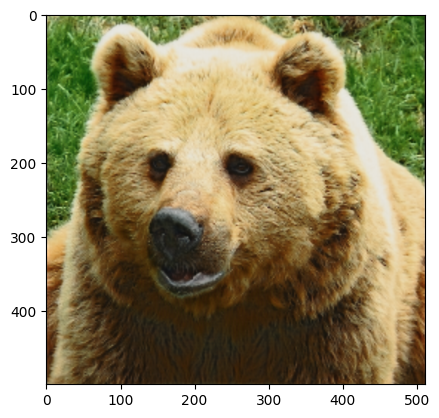

In [27]:
import matplotlib.pyplot as plt
plt.imshow(best_result['The large brown bear has a black nose.']['output'][0].transpose(2,1,0))

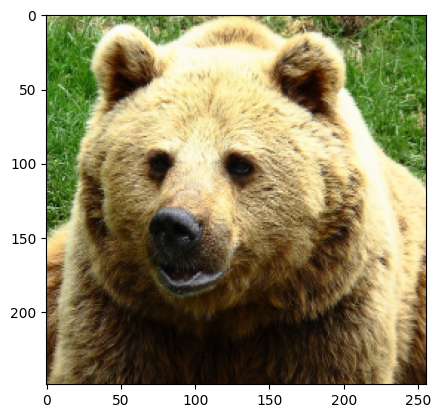

In [28]:
c, h, w = best_result['The large brown bear has a black nose.']['cropped'][0].shape
plt.imshow(resize(best_result['The large brown bear has a black nose.']['cropped'][0], (h//down_scale,w//down_scale)).permute(2,1,0))

In [41]:
save_imgs(best_result, f'resultsX{down_scale}x2-real_inverse_with_downsampler_noSF')

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'resultsX8x2-real_inverse_with_downsampler_noSF\\A_room_with_chairs,_a_table,_and_a_woman_in_it.'

In [23]:
os.mkdir('./resultsX8x2withDetection\\Three stuffed animals are sitting on a bed.\\three stuffed animals')

'three stuffed animals'

In [31]:
down_scale

8

In [68]:
with open(file=f'resultsX{down_scale}x2-inver_re_l1_l2_50epoch.pkl', mode='rb') as f:
    dicdic=pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'resultsX8x2-inver_re_l1_l2_50epoch.pkl'

In [ ]:
dicdic

In [ ]:
best_result['Three stuffed animals are sitting on a bed. ']["phrases"][0][0]

In [ ]:
best_result['']

In [29]:
import pickle

with open(f'./resultsX{down_scale}x2-vanilla.pkl','wb') as fw:
    pickle.dump(best_result, fw)

In [30]:
path = './result_model/X8_x2-vanilla.pt'
torch.save(best_model, path)

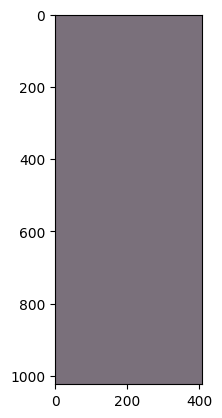

In [17]:
import matplotlib.pyplot as plt
plt.imshow(best_result['A room with chairs, a table, and a woman in it.']['output'][0].transpose(2,1,0))

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

print("PSNR :", peak_signal_noise_ratio(Test_result_img['output'][0], Test_result_img['big_image'][0]))
print("SSIM :", structural_similarity((Test_result_img['output'][0]*255).astype(np.uint8), (Test_result_img['big_image'][0]*255).astype(np.uint8), channel_axis=2,multichannel=True))

In [15]:
nn.Parameter(torch.randn((64))).shape

torch.Size([64])

In [16]:
nn.Parameter(torch.ones((64))).shape

torch.Size([64])

In [59]:
import torch.nn as nn
import torch
sf = nn.Softmax()

a = nn.Parameter(torch.randn((1,1,64,64)))
b = nn.Parameter(torch.randn(1,128,64,64))
print(sf(b).max(dim=1)[0].shape)
print((a.flatten()@b.mean(dim=1).flatten()).shape)


torch.Size([1, 64, 64])
torch.Size([])


C:\Users\juniy\AppData\Local\Temp\ipykernel_14140\2370105043.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(sf(b).max(dim=1)[0].shape)


In [37]:
b.mean(dim=1).shape

torch.Size([1, 64, 64])

In [53]:
torch.dot(a.view(-1,64), b.mean(dim=1).view(-1,64))

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [70]:
sf = nn.Softmax(dim=-1)
sf(a@b.mean(dim=1).transpose(-2,-1)).shape

torch.Size([1, 1, 64, 64])